# VAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import modelVAE

## 学習データ作成

In [ ]:

# Dataset = dataset.dataset("Obrid_AE", "data")
# Dataset.concat_data("sample_data",500)
# Dataset = dataset.dataset("Obrid_AE", "test")
# print("----------------------")
# Dataset.concat_data("sample_test",100)
# print("----------------------")
# data = Dataset.read_savedata("sample_test")
# print(data.shape[0])
# print("----------------------")
# # data, test_data , anomaly_data= Dataset.read_traindata("sample_data", "sample_test", 2000, 1024, 1)
# data, ori_data, test_data , anomaly_data= Dataset.read_Auged_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_train/train.npy", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_anomaly/anomaly.npy", 1000, 256, 1, readType=False)


## OldSensor


In [ ]:

# Dataset = dataset.dataset(npyFlag=True)
# epochStr = 4000
# epochSizeStr = 128
# data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/train/train1226.csv", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/anomaly/anomaly1226.csv", epochStr, epochSizeStr, 1, readType=True)


## NewSensor

In [ ]:

Dataset = dataset.dataset(npyFlag=True)
epochStr = 1000
epochSizeStr = 128
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_train/train.npy", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_anomaly/anomaly.npy", epochStr, epochSizeStr, 1, readType=False)


## モデル学習

In [ ]:
#netよう
z_dim = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = modelVAE.VAE_cnn_net(z_dim, device).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
input_data = torch.from_numpy(data.astype(np.float32)).clone()
ori_data = torch.from_numpy(ori_data.astype(np.float32)).clone()
input_test_data = torch.from_numpy(test_data.astype(np.float32)).clone()

model.train()
loss_list = []
cnt = 0
# input_data = input_data[0:300]
for epoch in input_data:
    losses = []
    cnt += 1
    for x in epoch:
        x = x.to(device) # データをGPUにのせる
        loss, z, y = model(x, device) # 損失関数の値 loss 、潜在ベクトル z 、再構築画像 y を出力
        model.zero_grad() # モデルの勾配を初期化
        loss.backward() # モデル内のパラメータの勾配を計算
        optimizer.step() # 最適化を実行
        losses.append(loss.cpu().detach().numpy()) # ミニバッチの損失を記録
    loss_list.append(np.average(losses)) # バッチ全体の損失を登録
    print("EPOCH: {} loss: {}".format(cnt, np.average(losses)))
    # for x in input_test_data:
    #     KL_loss, reconstruction_loss = model.loss(x)
    #     loss = KL_loss + reconstruction_loss
    #     losses_val.append(loss.cpu().detach().numpy())

    # print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
    #     (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses)))

In [ ]:
# z_dim = 8
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = modelVAE.VAE_cnn(z_dim, device).to(device)
# # optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
# input_data = torch.from_numpy(data.astype(np.float32)).clone()
# input_test_data = torch.from_numpy(test_data.astype(np.float32)).clone()
# for epoch in input_data:
#     losses = []
#     KL_losses = []
#     reconstruction_losses = []
#     model.train()
#     for x in epoch:
#         x = x.to(device)
#         model.zero_grad()
#         KL_loss, reconstruction_loss = model.loss(x)  # lossの各項の計算
#         loss = KL_loss + reconstruction_loss  # 和を取ってlossとする
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.detach().numpy())
#         KL_losses.append(KL_loss.detach().numpy())
#         reconstruction_losses.append(reconstruction_loss.detach().numpy())

#     losses_val = []
#     model.eval()
#     # for x in input_test_data:
#     #     KL_loss, reconstruction_loss = model.loss(x)
#     #     loss = KL_loss + reconstruction_loss
#     #     losses_val.append(loss.cpu().detach().numpy())

#     # print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
#     #     (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses)))

## モデルの保存

In [ ]:
folder_name = "newSensor"
model_name = "VAE_cnn_net"+str(z_dim)+"epoch_"+str(epochStr)+"epockSize_"+str(epochSizeStr)
ModelEdit = mainmodel.Modeledit(folder_name,model_name)
ModelEdit.save_model(model)

## 確認だよーん

normal:5.365918267518282
anomarly:22.694038573652506
anomaly
normal:5.349727349355817
anomarly:12.41443942557089
anomaly
normal:7.901429366320372
anomarly:12.025807330501266
anomaly
normal:4.359039356466383
anomarly:19.074727341532707
anomaly
normal:9.680117237381637
anomarly:27.62277859263122
anomaly
normal:4.625854515936226
anomarly:12.058506636181846
anomaly
normal:9.768827924504876
anomarly:10.722323623951524
anomaly
normal:6.454448003321886
anomarly:42.7835355065763
anomaly
normal:4.922591322101653
anomarly:11.400933043216355
anomaly
normal:15.053981725126505
anomaly
anomarly:7.730233984882943
normal:18.00245302915573
anomaly
anomarly:32.94522438570857
anomaly
normal:6.316447112709284
anomarly:14.167287413030863
anomaly
normal:7.548057310283184
anomarly:8.795471638441086
normal:7.002047449350357
anomarly:17.510268121026456
anomaly
normal:11.545725658535957
anomaly
anomarly:27.194241899996996
anomaly
normal:4.529544318560511
anomarly:35.872813700698316
anomaly
normal:7.039135005325

/var/folders/gl/kcbdb7pj0yz8846ytcdrjm140000gn/T/ipykernel_34933/1411197911.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/gl/kcbdb7pj0yz8846ytcdrjm140000gn/T/ipykernel_34933/1411197911.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


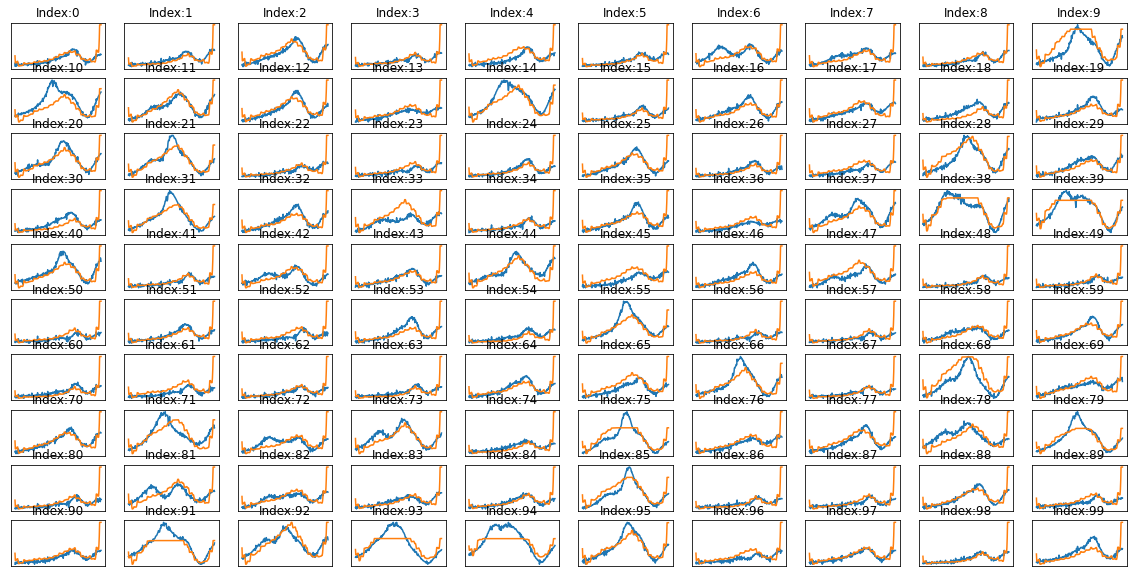

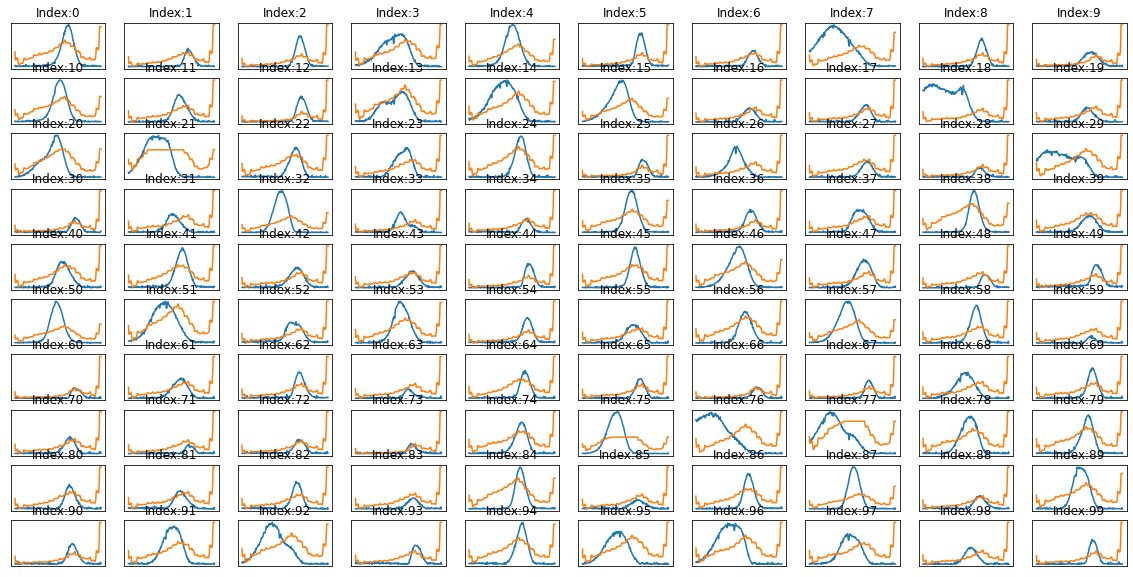

In [123]:
# # num = 5
# data0 =  torch.from_numpy((test_data[0]).astype(np.float32)).clone()
# data0 = data0[np.newaxis, np.newaxis, :]
# loss, z, recon = model(data0, device)
# # recon, _ = model(data0)
# recon = recon.detach()
# print(recon)

fig = plt.figure(figsize=(20, 10))
fig2 = plt.figure(figsize=(20, 10))
figroot = round(np.square(anomaly_data.shape[0]))
model.eval()
# for i in range(anomaly_data.shape[0]):
for i in range(100):
    if i % 1 == 0:
        try:
            data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
            input_data = data0[np.newaxis, np.newaxis, :]
            loss, z, recon = model(input_data, device)
            recon = recon.detach().numpy()
            ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
            title = "Index:"+str(i)
            ax.set_title(title)
            ax.plot(data0.numpy())
            ax.plot(recon.flatten())
            
            anomalypoint=sum(abs(recon.flatten()-data0.numpy()))
            print("normal:"+str(anomalypoint))
            if(anomalypoint>10):
                print("anomaly")
                
            # data = test0.numpy()
            test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
            input_data = test0[np.newaxis, np.newaxis, :]
            # recon,_ = model(input_data)
            loss, z, recon = model(input_data, device)
            recon = recon.detach().numpy()
            ax = fig2.add_subplot(10, 10, i+1, xticks=[], yticks=[])
            title = "Index:"+str(i)
            ax.set_title(title)
            ax.plot(test0.numpy())
            ax.plot(recon.flatten())
            
            anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
            print("anomarly:"+str(anomalypoint))
            if(anomalypoint>10):
                print("anomaly")
        except IndexError: 
            print("Finish")
            break
fig.show()
fig2.show()

In [59]:

Dataset = dataset.dataset(npyFlag=True)
epochStr = 100
epochSizeStr = 128
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/train/train1226.csv", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/anomaly/anomaly1226.csv", epochStr, epochSizeStr, 1, readType=True)
model_name = "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/VAEOKepoch_10epockSize_128/20211228/VAEOKepoch_10epockSize_128035434.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 5
input_model = modelVAE.VAE_cnn_net(z_dim, device).to(device)
input_model.eval()
input_model.load_state_dict(torch.load(model_name, map_location=device))
model = input_model


(2560, 256)
(179, 256)
706 0
rate 0.9
data.shape[0]: 2560
rate 2304
TrainData (100, 128, 1, 1, 256)
TestData (256, 256)
ÄnomalyDta (179, 256)


Error:0
anomalyScore:0.5310407857760885


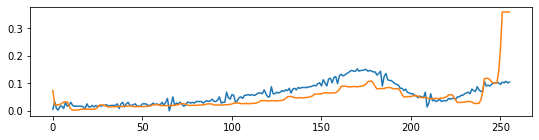

Error:100
anomalyScore:0.4734374190471389


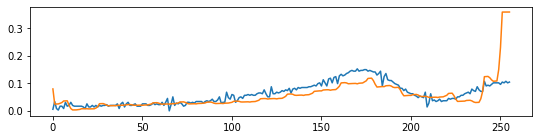

TH:0.6
normalData:179
Correct[%]97.76536312849161%
anomalyData:179
Correct[%]100.0%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


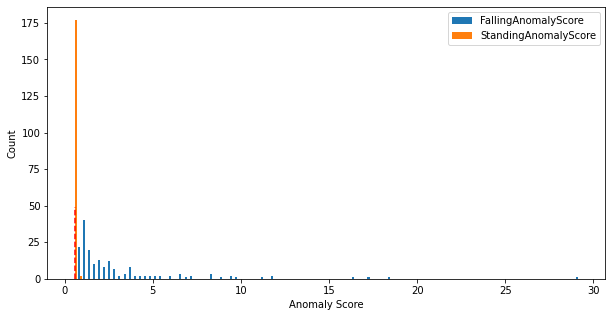

Conbi Data


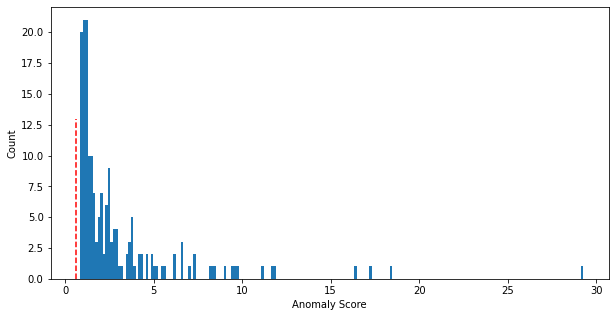

FallingAnomalyScore


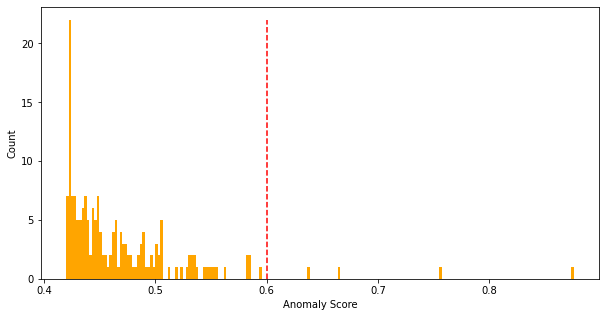

StandingAnomalyScore
standingAnomalyScore
TH:0.42
[0.53, 0.42, 0.45, 0.43, 0.45, 0.5, 0.43, 0.42, 0.42, 0.47, 0.47, 0.44, 0.43, 0.43, 0.43, 0.43, 0.49, 0.5, 0.43, 0.5, 0.47, 0.51, 0.48, 0.45, 0.42, 0.55, 0.43, 0.51, 0.44, 0.42, 0.44, 0.42, 0.49, 0.42, 0.42, 0.44, 0.5, 0.45, 0.42, 0.43, 0.45, 0.42, 0.46, 0.44, 0.44, 0.47, 0.43, 0.48, 0.58, 0.49, 0.42, 0.44, 0.45, 0.76, 0.43, 0.44, 0.48, 0.43, 0.45, 0.45, 0.51, 0.45, 0.56, 0.48, 0.53, 0.44, 0.42, 0.42, 0.42, 0.54, 0.44, 0.42, 0.58, 0.5, 0.47, 0.45, 0.46, 0.47, 0.45, 0.49, 0.47, 0.44, 0.5, 0.43, 0.55, 0.47, 0.49, 0.52, 0.44, 0.46, 0.42, 0.58, 0.59, 0.43, 0.55, 0.54, 0.43, 0.44, 0.66, 0.42, 0.47, 0.44, 0.44, 0.46, 0.44, 0.44, 0.42, 0.46, 0.47, 0.42, 0.55, 0.43, 0.88, 0.45, 0.45, 0.53, 0.55, 0.42, 0.44, 0.44, 0.48, 0.53, 0.52, 0.49, 0.42, 0.46, 0.45, 0.42, 0.42, 0.44, 0.43, 0.47, 0.45, 0.53, 0.42, 0.5, 0.5, 0.42, 0.46, 0.43, 0.5, 0.5, 0.42, 0.45, 0.43, 0.45, 0.44, 0.43, 0.54, 0.48, 0.49, 0.42, 0.53, 0.46, 0.42, 0.64, 0.43, 0.44, 0.42, 0.49,

In [61]:
import statistics
import scipy
AnomalyCorrectPoint = 0
StandardCorrectPoint = 0
anomalyScoreList=[]
thr = 0.6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


for i in range(anomaly_data.shape[0]):
    try:
# num = 5
        data0 =  torch.from_numpy((test_data[0]).astype(np.float32)).clone()
        data = data0[np.newaxis, np.newaxis, :]
        loss, z, recon = model(data, device)
        # recon, _ = model(data0)
        recon = recon.detach().numpy()

        anomalyScoreList.append(sum((recon.flatten()-data0.numpy())**2))
        
        # if(anomalyScoreList[i]<=thr):
        if(False):
            pass
        else:
            if i % 100 == 0:
                print('Error:'+str(i))
                print('anomalyScore:'+str(anomalyScoreList[i]))
                plt.figure(figsize=(9, 2))
                plt.plot(data0.numpy())
                plt.plot(recon.flatten())
                plt.show()             
    except IndexError:
        pass
roundList = [round(i,2) for i in anomalyScoreList]
# thr = np.min(anomalyScoreList)
# thr = scipy.stats.mode(anomalyScoreList)
# thr = min(statistics.multimode(roundList))

print("TH:{}".format(thr))
# print(roundList)
for i in range(anomaly_data.shape[0]):
    try:
        if(anomalyScoreList[i]<=thr):
            StandardCorrectPoint += 1
    except IndexError:
        pass
print('normalData:'+str(anomaly_data.shape[0]))
print('Correct[%]'+str(100*StandardCorrectPoint/anomaly_data.shape[0])+'%')
standingAnomalyScore = anomalyScoreList
AnomalyCorrectPoint = 0
StandardCorrectPoint = 0
anomalyScoreList=[]
for i in range(anomaly_data.shape[0]):
    
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        data = test0[np.newaxis, np.newaxis, :]
        loss, z, recon = model(data, device)
        recon = recon.detach().numpy()

        anomalyScoreList.append(sum((recon.flatten()-test0.numpy())**2))
        if(anomalyScoreList[i]>thr):
            AnomalyCorrectPoint += 1

print('anomalyData:'+str(anomaly_data.shape[0]))
print('Correct[%]'+str(100*AnomalyCorrectPoint/anomaly_data.shape[0])+'%')
fallingAnomalyScore = anomalyScoreList



plt.figure(figsize=(10, 5))
plt.hist([fallingAnomalyScore,standingAnomalyScore],label=['FallingAnomalyScore','StandingAnomalyScore'],bins=100)
plt.vlines([thr], 0, 49, "red", linestyles='dashed')
plt.legend()
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.savefig("scoreHist.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()
print("Conbi Data")
plt.figure(figsize=(10, 5))
plt.hist(fallingAnomalyScore,label='FallingAnomalyScore',bins=200)
plt.vlines([thr], 0, 13, "red", linestyles='dashed',label='threshold')
# plt.legend()
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.savefig("fallingScoreHist.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()
print("FallingAnomalyScore")
plt.figure(figsize=(10, 5))
plt.hist(standingAnomalyScore,label='StandingAnomalyScore',bins=200,color='orange')
plt.vlines([thr], 0, 22, "red", linestyles='dashed')
# plt.legend()
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.savefig("standingScoreHist.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()
print("StandingAnomalyScore")
print("standingAnomalyScore")
roundList = [round(i,2) for i in standingAnomalyScore]
thr = min(statistics.multimode(roundList))
print("TH:{}".format(thr))
print(roundList)
print("fallingAnomalyScore")
roundList = [round(i,2) for i in fallingAnomalyScore]
thr = min(statistics.multimode(roundList))
print("TH:{}".format(thr))
print("MIN:{}".format(min(roundList)))
print(roundList)

## 潜在変数からランダムサンプリング　

/var/folders/gl/kcbdb7pj0yz8846ytcdrjm140000gn/T/ipykernel_34933/3021944000.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


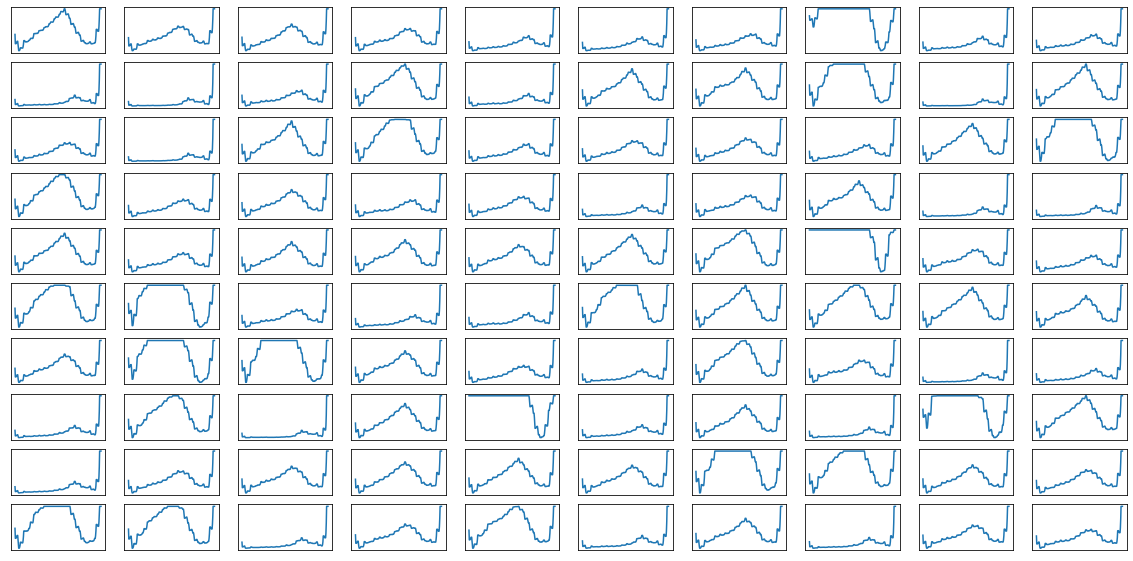

In [124]:
fig = plt.figure(figsize=(20, 10))
model.eval()
for i in range(100):
    z = torch.randn([z_dim]).to(device)
    # print(z)
    recon = model._decoder(z)
    recon = recon.detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.plot(recon.flatten())
fig.show()

## 潜在空間の多様体の可視化

[0.07365439 0.08215298 0.07932011 0.0651558  0.08215298 0.0878187
 0.08498584 0.0878187  0.08498584 0.07365439 0.101983   0.09915014
 0.10764872 0.09065156 0.09065156 0.09631728 0.09631728 0.101983
 0.09915014 0.11048159 0.09915014 0.10481586 0.10481586 0.11048159
 0.11331445 0.11331445 0.11331445 0.11331445 0.11898017 0.12181303
 0.12747875 0.12747875 0.13031161 0.13314448 0.14164306 0.1388102
 0.14447592 0.14164306 0.15014164 0.15014164 0.13597734 0.1756374
 0.15580736 0.15580736 0.16713881 0.16713881 0.17280453 0.17280453
 0.1756374  0.18413597 0.18413597 0.16997167 0.1756374  0.18130311
 0.18130311 0.18130311 0.19830029 0.20113315 0.20113315 0.203966
 0.203966   0.20679887 0.20113315 0.21529745 0.22379604 0.2181303
 0.21246459 0.23229462 0.203966   0.21529745 0.2181303  0.22096318
 0.23796034 0.22096318 0.21246459 0.22096318 0.22379604 0.22379604
 0.22379604 0.2181303  0.22096318 0.22379604 0.22096318 0.21246459
 0.20679887 0.21529745 0.21246459 0.21246459 0.21246459 0.21529745
 0.

/var/folders/gl/kcbdb7pj0yz8846ytcdrjm140000gn/T/ipykernel_34933/3094868643.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


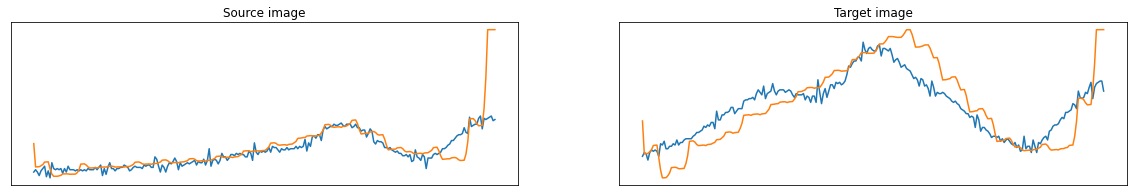

In [137]:
saveForder = '修論用データ/'
fig = plt.figure(figsize=(20, 3))
sorce = 1
target = 92
model.eval()
data0 =  torch.from_numpy((test_data[sorce]).astype(np.float32)).clone()
data = data0[np.newaxis, np.newaxis, :]
loss, z0, y0 = model(data, device)
y0 = y0.detach().numpy().flatten()
z0 = z0.detach().numpy().flatten()
data0 = data0.numpy()
ax0 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax0.set_title('Source image')
ax0.plot(data0)
ax0.plot(y0)
np.savez(saveForder+"/Manifold_z_sorce", data0,y0, z0)

data0 =  torch.from_numpy((test_data[target]).astype(np.float32)).clone()
data = data0[np.newaxis, np.newaxis, :]
loss, z1, y0 = model(data, device)
y0 = y0.detach().numpy().flatten()
z1 = z1.detach().numpy().flatten()
data0 = data0.numpy()
ax0 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax0.set_title('Target image')
ax0.plot(data0)
ax0.plot(y0)
print("------------------")
print(data0,y0, z1)
np.savez(saveForder+"/Manifold_z_target", data0,y0, z1)
z = np.load(saveForder+"/Manifold_z_target"+".npz")
print("------------------")
print(z['arr_0'], z['arr_1'], z['arr_2'])

fig.show()

[tensor([-0.6984,  0.0027, -0.4784,  0.5019,  0.1418], grad_fn=<AddBackward0>), tensor([-0.5695,  0.0777, -0.3300,  0.3964,  0.2015], grad_fn=<AddBackward0>), tensor([-0.4405,  0.1528, -0.1815,  0.2909,  0.2612], grad_fn=<AddBackward0>), tensor([-0.3115,  0.2278, -0.0331,  0.1853,  0.3209], grad_fn=<AddBackward0>), tensor([-0.1825,  0.3029,  0.1153,  0.0798,  0.3807], grad_fn=<AddBackward0>), tensor([-0.0536,  0.3780,  0.2637, -0.0258,  0.4404], grad_fn=<AddBackward0>), tensor([ 0.0754,  0.4530,  0.4121, -0.1313,  0.5001], grad_fn=<AddBackward0>), tensor([ 0.2044,  0.5281,  0.5606, -0.2369,  0.5598], grad_fn=<AddBackward0>), tensor([ 0.3333,  0.6032,  0.7090, -0.3424,  0.6195], grad_fn=<AddBackward0>), tensor([ 0.4623,  0.6782,  0.8574, -0.4480,  0.6793], grad_fn=<AddBackward0>)]


/var/folders/gl/kcbdb7pj0yz8846ytcdrjm140000gn/T/ipykernel_34933/3352904562.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


y2 [array([0.09098864, 0.03114227, 0.0314821 , 0.0317078 , 0.03429425,
       0.03737694, 0.04395924, 0.04437305, 0.04464752, 0.02641595,
       0.01169519, 0.00501159, 0.00510449, 0.00516658, 0.00628708,
       0.00798939, 0.01166955, 0.01184529, 0.01196241, 0.01168917,
       0.01084613, 0.01097191, 0.01113995, 0.01125196, 0.01511422,
       0.02237718, 0.03772254, 0.03810286, 0.03835525, 0.03548628,
       0.03076606, 0.02799379, 0.0283121 , 0.02852358, 0.0287789 ,
       0.02827677, 0.02977711, 0.0301078 , 0.03032745, 0.03088503,
       0.03078841, 0.03288701, 0.03323815, 0.03347129, 0.03301331,
       0.03142501, 0.03182049, 0.03216477, 0.0323934 , 0.03243801,
       0.0315657 , 0.03277693, 0.03312737, 0.03336006, 0.0358672 ,
       0.03877347, 0.04513496, 0.04555462, 0.04583292, 0.04423432,
       0.04092176, 0.03981006, 0.04020208, 0.04046219, 0.04062242,
       0.03978502, 0.0413538 , 0.04175415, 0.04201974, 0.0439547 ,
       0.045759  , 0.05079843, 0.05124429, 0.05153983, 0.0

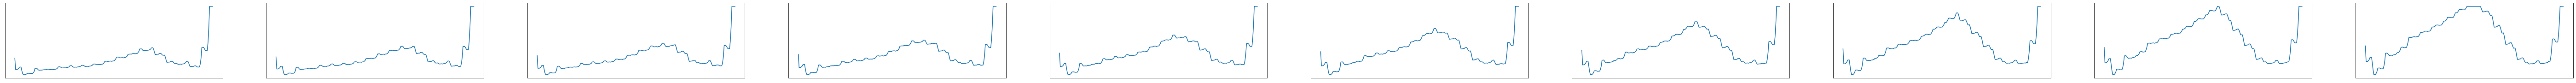

In [133]:
fig = plt.figure(figsize=(100, 3))
z_linear = [z1 * (i * 0.1) + z0 * ((9 - i) * 0.1) for i in range(10)]
print(z_linear)
y2 = [model._decoder(i).detach().numpy().flatten() for i in z_linear]
for i, im in enumerate(y2):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.plot(im)
fig.show()
print("y2", y2)
np.save(saveForder+"/Manifold_z_Seaquence", y2)
print("load", np.load(saveForder+"/Manifold_z_Seaquence"+".npy"))

    # z = torch.randn([z_dim]).to(device)
    # # print(z)
    # recon = model._decoder(z)
    # recon = recon.detach().numpy()
    # ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    # ax.plot(recon.flatten())

## OCSVM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import modelVAE
from LossFunction import SSIMLoss #自作Loss関数
import LossFunction
import dataloader

In [ ]:
# model_name = "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/VAEOKepoch_10epockSize_128/20211228/VAEOKepoch_10epockSize_128035434.pth"

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# z_dim = 5
# input_model = modelVAE.VAE_cnn_net(z_dim, device).to(device)
# input_model.eval()
# # input_model = input_mode.to(device)
# input_model.load_state_dict(torch.load(model_name, map_location=device))
input_model = model
Dataset = dataset.dataset(npyFlag=True)
epochStr = 50
epochSizeStr = 512
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_train/train.npy", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_anomaly/anomaly.npy", epochStr, epochSizeStr, 1, readType=False)
data = dataloader.ocsvm_DAE_dataset(data)
#OCSVM用再構成後データセットロード
recon_list, encoded_list, input_list = dataloader.ocsvm_dataset_VAEmodel(input_model, device, data)
test_recon_list, test_encoded_list, test_input_list = dataloader.ocsvm_dataset_VAEmodel(input_model, device, test_data)
anomaly_recon_list, anomaly_encoded_list, anomaly_input_list = dataloader.ocsvm_dataset_VAEmodel(input_model, device, anomaly_data)


In [ ]:
from sklearn.svm import OneClassSVM

X_anomaly = anomaly_encoded_list
X_test = test_encoded_list
# X_train = encoded_list[0:256]
X_train = encoded_list

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from sklearn import svm
import matplotlib.font_manager
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

SPACE_SAMPLING_POINTS = 100
TRAIN_POINTS = 100

# Define the size of the space which is interesting for the example
X_MIN = -100
X_MAX = 100
Y_MIN = -100
Y_MAX = 100
Z_MIN = -100
Z_MAX = 100

# Generate a regular grid to sample the 3D space for various operations later
xx, yy, zz = np.meshgrid(np.linspace(X_MIN, X_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Y_MIN, Y_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Z_MIN, Z_MAX, SPACE_SAMPLING_POINTS))

# Generate some abnormal novel observations using a different distribution
X_outliers = np.random.uniform(low=-10, high=10, size=(20, 3))

# Create a OneClassSVM instance and fit it to the data
clf = svm.OneClassSVM(nu=0.009, kernel="rbf", gamma=0.8)
clf.fit(X_train)
# Predict the class of the various input creaxted before
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_anomaly = clf.predict(X_anomaly)
# y_pred_normal = clf.predict(X_anomaly)
y_pred_outliers = clf.predict(X_outliers)
print("y_pred_train:{} ".format(y_pred_train.shape[0] ))
print("y_pred_anomaly:{} ".format(y_pred_anomaly ))
print("y_pred_outliers:{} ".format(y_pred_outliers ))
# And compute classification error frequencies
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_anomaly = y_pred_anomaly[y_pred_anomaly == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
error_train = y_pred_train[y_pred_train == -1]
error_anomaly = y_pred_anomaly[y_pred_anomaly == -1]
error_test = y_pred_test[y_pred_test == 1]
# Calculate the distance from the separating hyperplane of the SVM for the
# whole space using the grid defined in the beginning
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
Z = Z.reshape(xx.shape)

# Create a figure with axes for 3D plotting
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.suptitle("Novelty Detection")

# Plot the different input points using 3D scatter plotting
b1 = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c='white', alpha=0.05)
# ax.scatter(error_train[:, 0],error_train[:, 1], error_train[:, 2], c='black', alpha=0.5)
b2 = ax.scatter(X_anomaly[:, 0], X_anomaly[:, 1], X_anomaly[:, 2], c='yellow', alpha=0.5)
# ax.scatter(error_anomaly[:, 0],error_anomaly[:, 1], error_anomaly[:, 2], c='red', alpha=0.5)
c = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c='cyan', alpha=0.5)
# ax.scatter(error_test[:, 0],error_test[:, 1], error_test[:, 2], c='magenta', alpha=0.5)
# Plot the separating hyperplane by recreating the isosurface for the distance
# == 0 level in the distance grid computed through the decision function of the
# SVM. This is done using the marching cubes algorithm implementation from
# scikit-image.
# verts, faces = measure.marching_cubes(Z, 0)
# # Scale and transform to actual size of the interesting volume
# verts = verts * \
#     [X_MAX - X_MIN, Y_MAX - Y_MIN, Z_MAX - Z_MIN] / SPACE_SAMPLING_POINTS
# verts = verts + [X_MIN, Y_MIN, Z_MIN]
# # and create a mesh to display
# mesh = Poly3DCollection(verts[faces],
#                         facecolor='orange', edgecolor='gray', alpha=0.3)
# ax.add_collection3d(mesh)

# # Some presentation tweaks
# ax.set_xlim((-5, 5))
# ax.set_ylim((-5, 5))
# ax.set_zlim((-5, 5))

# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.legend([mpatches.Patch(color='orange', alpha=0.3), b1, b2, c],
#     ["learned frontier", "training observations",
#     "new regular observations", "new abnormal observations"],
#     loc="lower left",
#     prop=matplotlib.font_manager.FontProperties(size=11))
ax.set_title(
    "error train: %d/%d ; errors anomaly: %d/%d ; "
    "error test: %d/%d "
    % (n_error_train, X_train.shape[0], n_error_anomaly, X_anomaly.shape[0], n_error_test, X_test.shape[0]))
fig.show()